In [37]:
import importlib
import utils
importlib.reload(utils)
from utils import *
from os import listdir
from os.path import join,basename

In [2]:
frame = skimage.io.imread(r'pics/fluid.jpg')
frame.shape

(2304, 3072, 3)

(700, 700, 295)


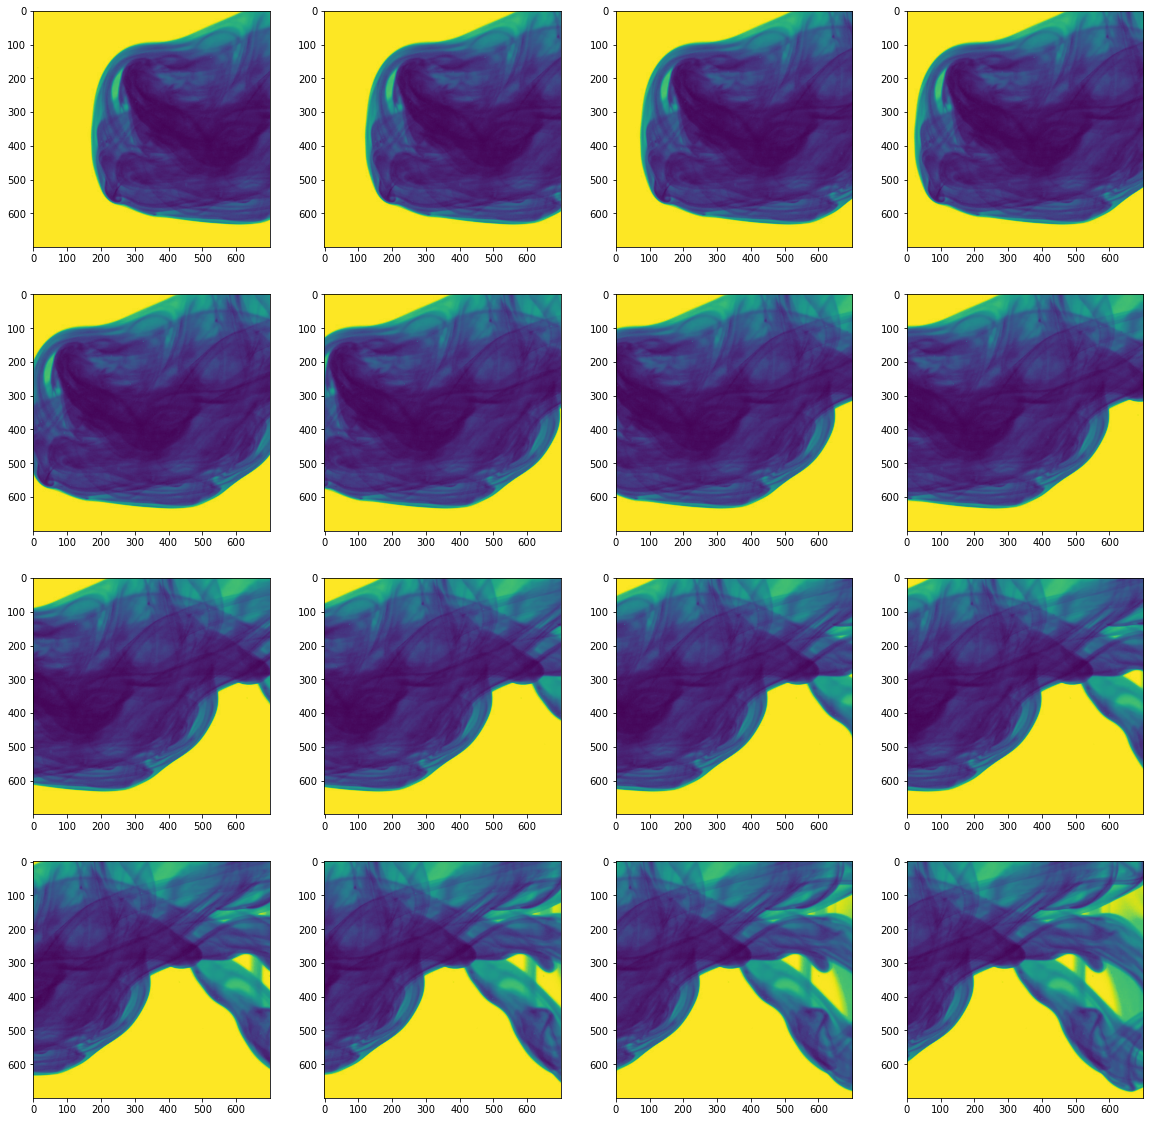

In [18]:
im_stack, coord_list = shift_images(shift_x=5,shift_y=0,frame=frame,dim=700,x0=900,y0=1400)
print(im_stack.shape)
show_image_sequence(im_stack,step_size=10)

Binary thresholding is not suitable because it is very sensitive to noises, and additional boats/barge might lead to misclassification of boundaries

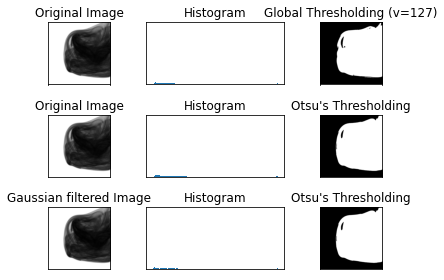

<Figure size 432x288 with 0 Axes>

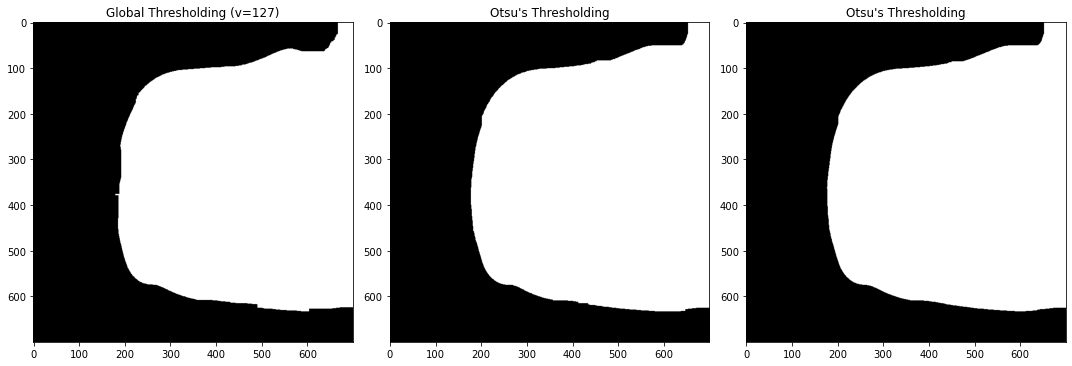

1


In [15]:
def create_binary_obj(im_stack):
    """
    im_stack (np.array) depth is temporal sequence of images
    create binary image using otsu thresholding
    """
    im = im_stack[:,:,0]*255
    im = im.astype(np.uint8)
    # global thresholding
    ret1,th1 = cv.threshold(im,127,255,cv.THRESH_BINARY_INV)
    # Otsu's thresholding
    ret2,th2 = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    # Otsu's thresholding after Gaussian filtering
    blur = cv.GaussianBlur(im,(5,5),0)
    ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

    #morphological operation
    kernel = np.ones((50,50),np.uint8)
    closed_list = []
    for i in [th1,th2,th3]:
        closing = cv.morphologyEx(i/255, cv.MORPH_CLOSE, kernel).astype(np.uint8)
        closed_list.append(closing)

    # plot all the images and their histograms
    images = [im, 0, th1,
            im, 0, th2,
            blur, 0, th3]
    titles = ['Original Image','Histogram','Global Thresholding (v=127)',
            'Original Image','Histogram',"Otsu's Thresholding",
            'Gaussian filtered Image','Histogram',"Otsu's Thresholding"]
    for i in range(3):
        plt.subplot(3,3,i*3+1),plt.imshow(images[i*3],'gray')
        plt.title(titles[i*3]), plt.xticks([]), plt.yticks([])
        plt.subplot(3,3,i*3+2),plt.hist(images[i*3].ravel(),256)
        plt.title(titles[i*3+1]), plt.xticks([]), plt.yticks([])
        plt.subplot(3,3,i*3+3),plt.imshow(images[i*3+2],'gray')
        plt.title(titles[i*3+2]), plt.xticks([]), plt.yticks([])
    plt.tight_layout()
    plt.show()

    plt.figure()
    fig, axes = plt.subplots(1,3,figsize=(15,5))
    for i,(ax,im) in enumerate(zip(axes.flatten(),closed_list)):
        ax.imshow(im,'gray')
        ax.set_title(titles[i*3+2])
    plt.tight_layout()
    plt.show()
    print(im.max())
    return


create_binary_obj(im_stack)


    

In [16]:
def binarize_obj(im_stack):
    """
    im_stack (np.array) depth is temporal sequence of images
    create binary image using otsu thresholding
    """
    closing_stack = np.zeros(im_stack.shape)
    for i in range(im_stack.shape[2]):
        im = im_stack[:,:,i]*255
        im = im.astype(np.uint8)
        # Otsu's thresholding after Gaussian filtering
        blur = cv.GaussianBlur(im,(5,5),0)
        ret3,th3 = cv.threshold(blur,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

        #morphological operation
        kernel = np.ones((50,50),np.uint8)
        closing = cv.morphologyEx(th3/255, cv.MORPH_CLOSE, kernel).astype(np.uint8)
        closing_stack[:,:,i] = closing
    
    return closing_stack


binary_stack = binarize_obj(im_stack)

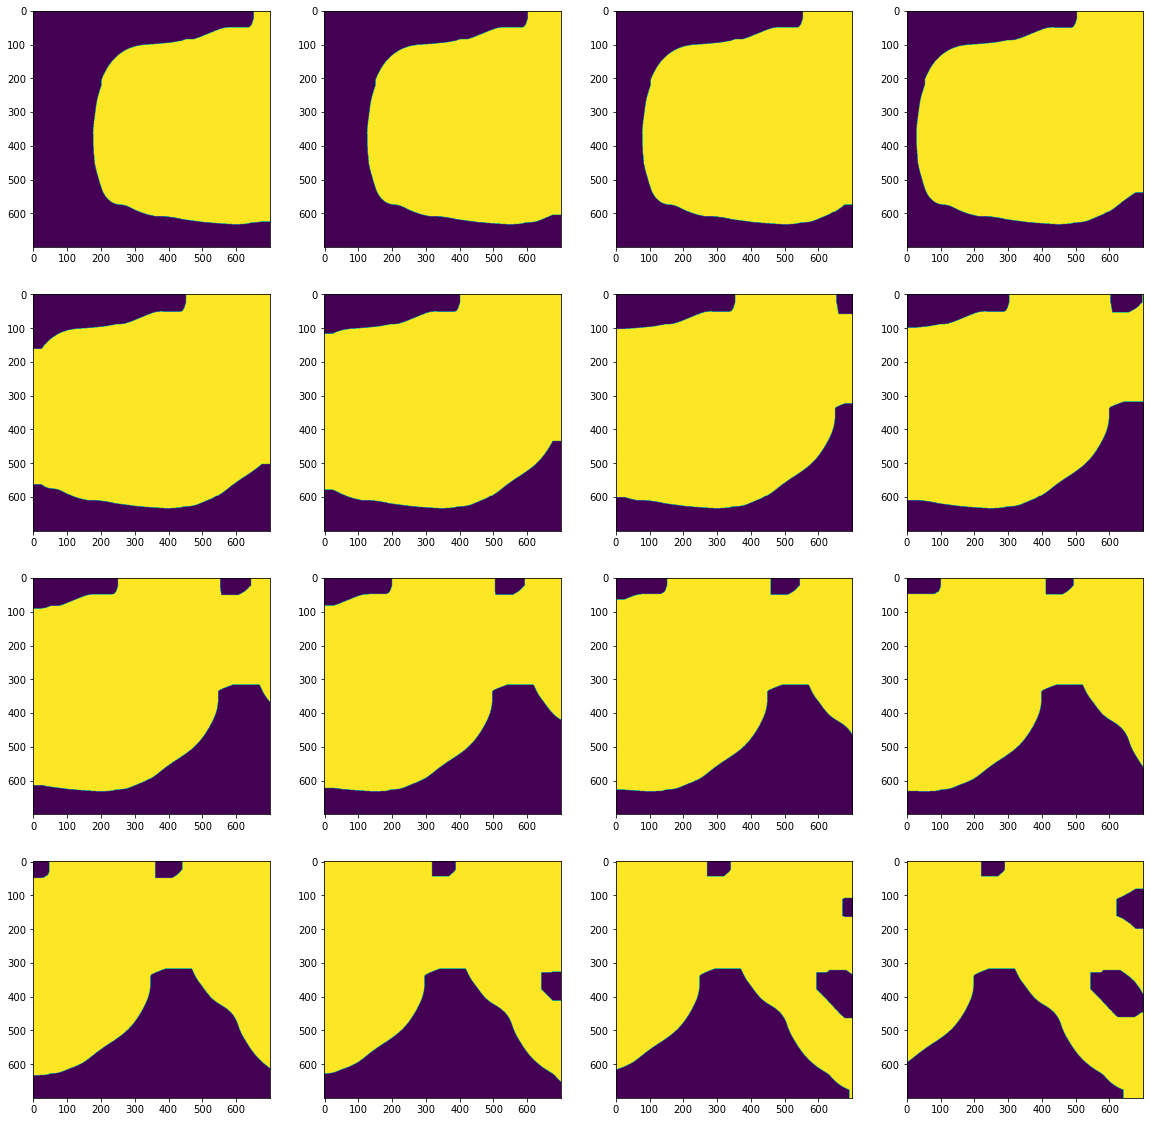

In [19]:
show_image_sequence(binary_stack,step_size=10)

# Optical flow of non-rigid bodies

In [20]:
binary_stack.shape

(700, 700, 295)

In [39]:
import importlib
import OF_plume.OF_algo
importlib.reload(OF_plume.OF_algo)
from OF_plume.OF_algo import *

In [41]:
FB_list = Gunner_Farneback(binary_stack,winsize=50)

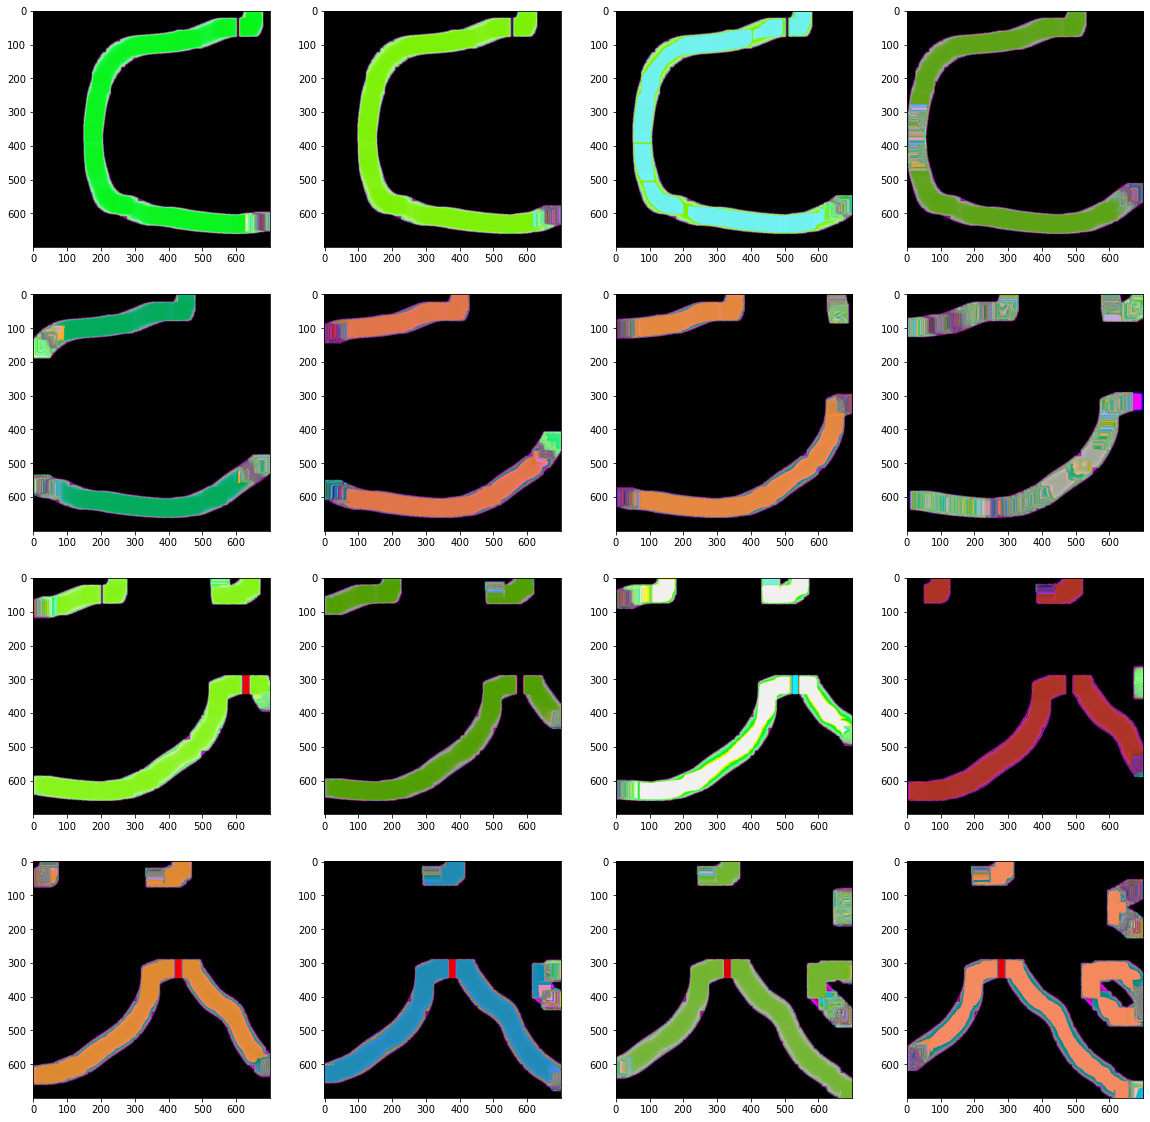

In [42]:
show_image_sequence(FB_list,step_size=10)

Max: 255, Min: 0
...........Done!


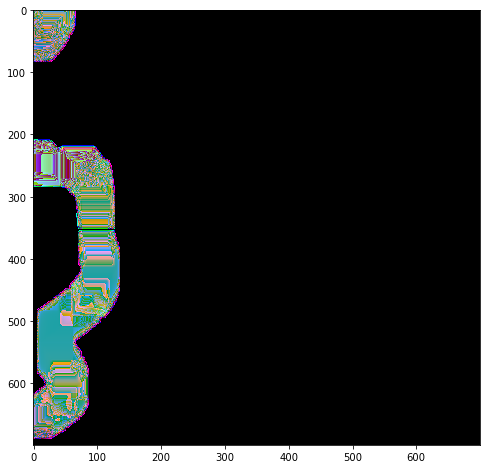

In [43]:
animate_frames(FB_list,'videos/binary_blob_50',fps=30)

c:\Users\PAKHUIYING\OneDrive - Nanyang Technological University\NTU\CFD\optical_flow_fluid\utils.py:201: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


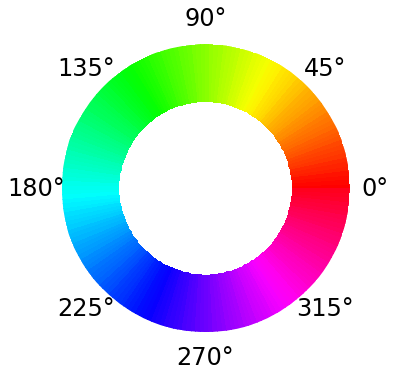

In [33]:
hsv_colour_wheel()

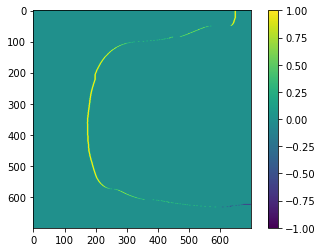

In [36]:

It = binary_stack[:,:,1] - binary_stack[:,:,0]
plt.figure()
im = plt.imshow(It)
plt.colorbar()
plt.show()

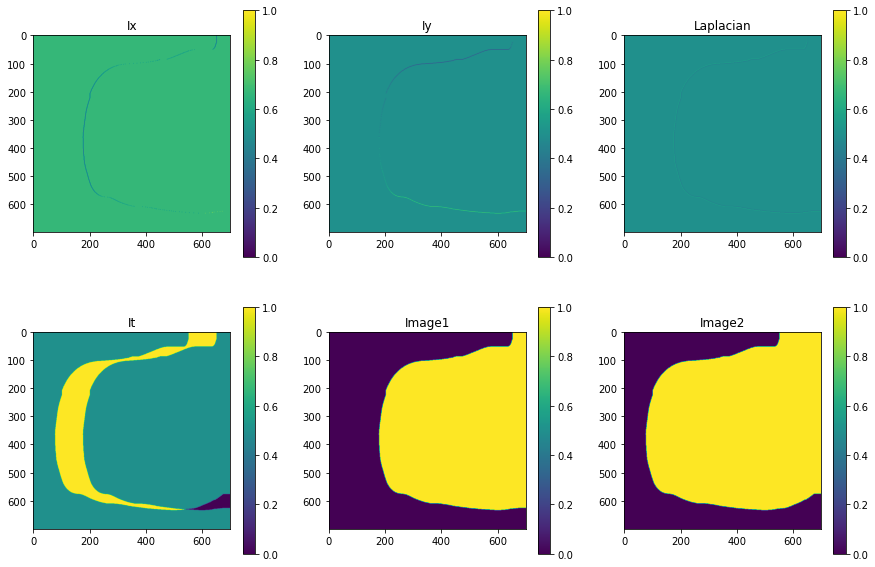

<Figure size 432x288 with 0 Axes>

In [57]:
fx,fy,ft = derivatives(binary_stack[:,:,0], binary_stack[:,:,20], plot_figure=True)

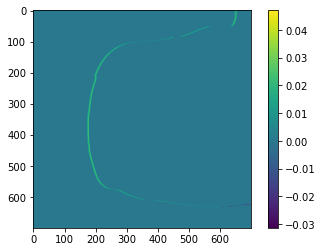

In [54]:
OF_constaint = fx*-5 + fy*0 + ft
plt.figure()
plt.imshow(OF_constaint)
plt.colorbar()